## Ensemble Model
- 기존에 존재하는 여러가지 알고리즘 모델을 결합 / 조합해서 새로운 형태의 강력한 알고리즘 생성

    - Voting: 서로 다른 알고리즘을 결합해서 가장 좋은 성능의 알고리즘을 찾아서 사용하는 기법
        - Train Data -> DT / Logistic / SVM / ... etc. Best Model
    - Bagging: 학습데이터에서 서로 다른 복원추출된 데이터를 하나의 알고리즘이 여러번 학습해서 나온 결과를 결합해서 하나의 강력한 모델을 구성
        - Sub Sampling: 1000개 데이터
            1) 700개 무작위 추출 -> DT 학습
            2) 700개 무작위 추출 -> DT 학습
            3) 700개 무작위 추출 -> DT 학습
                이렇게 학습된 Model을 결합
    - Boosting: 앞서 Bagging 기법과 같이 복원추출된 데이터를 하나의 모델이 학습하고, 학습을 수행할 때마다 이전의 학습 결과를 반영해서 다음 복원추출 단계에 반영해서 학습
        - DT Model: 비모수데이터에 잘 작동함 / 과적합

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import plotly.express as px

mpl.rc('font', family = 'Malgun Gothic')

In [2]:
df1 = pd.read_csv("11_Data.csv", encoding = 'utf-8')
df1

,Unnamed: 0,Ox_Chamber,process,type,Temp_OXid,Vapor,ppm,Pressure,Oxid_time,thickness,...,Flux480s,Flux840s,input_Energy,Temp_implantation,Furance_Temp,RTA_Temp,Target,Error_message,target_binom,Chamber_Route
0,0,1,Oxidation,dry,1138.979159,O2,32.80,0.200,62.0,699.443,...,3.002593e+17,6.000007e+17,31574.410,102.847,885.0,154,96,none,0.0,route_11133
1,1,1,Oxidation,dry,1218.184551,O2,31.86,0.194,137.0,696.792,...,3.017903e+17,6.000012e+17,31580.213,104.323,919.0,154,102,none,0.0,route_11222
2,2,1,Oxidation,dry,1062.467808,O2,39.51,0.217,128.0,705.471,...,2.994231e+17,6.000002e+17,32162.414,100.605,916.0,155,95,none,0.0,route_11311
3,3,1,Oxidation,dry,1114.704773,O2,32.88,0.201,90.0,710.772,...,2.991354e+17,6.000003e+17,32874.925,101.739,911.0,156,117,none,0.0,route_12111
4,4,1,Oxidation,dry,989.411946,O2,38.11,0.204,98.0,716.975,...,3.005576e+17,6.000013e+17,30985.928,106.422,872.0,155,143,none,0.0,route_12222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,845,3,Oxidation,wet,1280.687973,H2O,45.19,0.214,21.0,708.586,...,2.995317e+17,5.999986e+17,32252.961,101.177,868.0,152,84,none,0.0,route_33111
748,846,3,Oxidation,wet,1275.153349,H2O,45.08,0.215,22.0,712.936,...,3.004926e+17,5.999991e+17,32253.818,100.736,868.0,151,105,none,0.0,route_33222
749,847,3,Oxidation,wet,1275.182502,H2O,45.10,0.214,21.0,715.498,...,3.009325e+17,6.000003e+17,32248.621,101.503,868.0,152,78,none,0.0,route_33333
750,848,1,Oxidation,wet,1268.105427,H2O,45.07,0.215,22.0,707.179,...,3.006733e+17,6.000003e+17,32241.426,101.061,867.0,152,42,none,0.0,route_11133


#### 1. 데이터셋 나누기 (X, Y)

In [3]:
Y = df1['target_binom']  # wafer 폐기 여부를 분류하는 알고리즘 구성
X = df1[['type', 'UV_type', 'thickness', 'resist_target', 'Line_CD', 'Etching_rate']]

In [4]:
# !pip install imblearn

#### 2. 필요한 라이브러리 로딩

In [5]:
# 훈련데이터와 검증데이터 분리
from sklearn.model_selection import train_test_split

# 컬럼 변환
from sklearn.compose import make_column_transformer

# 파이프라인 만들기
from imblearn.pipeline import make_pipeline

# 결측치 대체 방법
from sklearn.impute import SimpleImputer, KNNImputer

# 전처리 방법
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# 데이터의 비율 맞춰주기
from imblearn.over_sampling import ADASYN

# 대표적인 배깅 모델
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 알고리즘 분류 결과 확인
from sklearn.metrics import classification_report

import pickle

#### 3. 학습/검증데이터 분할

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1234)

#### 4. 파이프라인 구성

In [7]:
numeric_pipe = make_pipeline(KNNImputer(), MinMaxScaler())
category_pipe = make_pipeline(SimpleImputer(strategy = 'most_frequent'), OneHotEncoder())

numeric_list = X.describe().columns.tolist()
category_list = X.describe(include = 'object').columns.tolist()

preprocess_pipe = make_column_transformer((numeric_pipe, numeric_list),
                                          (category_pipe, category_list))

model_pipe = make_pipeline(preprocess_pipe, ADASYN(), RandomForestClassifier())

#### 5. 교차검증 및 하이퍼파라미터 튜닝

In [8]:
hyperparameter_list = {'randomforestclassifier__max_depth':range(5,11),
                      'randomforestclassifier__min_samples_leaf':range(5,11),
                      'randomforestclassifier__min_samples_split': range(5,11)}

grid_model = GridSearchCV(model_pipe, param_grid=hyperparameter_list, cv = 5, n_jobs = -1, scoring = 'f1')
grid_model.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('knnimputer',
                                                                                          KNNImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['thickness',
                                                                          'resist_target',
                                                                          'Line_CD',
                                                                          'Etching_rate']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['type',
                                                                          'UV_type'])])),
                                       ('adasyn', ADASYN()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(5, 11),
                         'randomforestclassifier__min_samples_leaf': range(5, 11),
                         'randomforestclassifier__min_samples_split': range(5, 11)},
             scoring='f1')

#### 6. 모델테스트

In [9]:
best_model = grid_model.best_estimator_
Y_train_pred = best_model.predict(X_train)
Y_test_pred = best_model.predict(X_test)

print(classification_report(Y_train, Y_train_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93       482
         1.0       0.41      0.93      0.57        44

    accuracy                           0.88       526
   macro avg       0.70      0.90      0.75       526
weighted avg       0.94      0.88      0.90       526



In [10]:
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.83      0.89       206
         1.0       0.23      0.50      0.31        20

    accuracy                           0.81       226
   macro avg       0.59      0.67      0.60       226
weighted avg       0.88      0.81      0.84       226



#### 변수 중요도 (Feature Importance) 추출
    - 분류를 수행함에 있어서 각 Feature가 얼마나 분류에 **기여**했는지
    - Data를 나눌 때 기여도가 높은 Column 확인
    - 회귀분석의 회귀계수의 개념과는 다름
    - 변수중요도가 높다고 해서 Y값이 직접적으로 변하지는 않음

#### 7. feature names 뽑기

In [11]:
best_model['randomforestclassifier'].feature_importances_

array([0.2437382 , 0.17935344, 0.1049947 , 0.34343261, 0.03231257,
       0.03091265, 0.01039457, 0.02916007, 0.02570119])

In [12]:
encoder_list = best_model.named_steps['columntransformer'].transformers_[1][1].named_steps['onehotencoder'].get_feature_names().tolist()
encoder_list

C:\Users\Conet\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['x0_dry', 'x0_wet', 'x1_G', 'x1_H', 'x1_I']

In [32]:
numeric_list = X.columns.tolist()

In [13]:
df_importance = pd.DataFrame()
df_importance['Feature'] = pd.Series(numeric_list + encoder_list)
df_importance['Importance'] = best_model['randomforestclassifier'].feature_importances_

In [29]:
print(best_model.named_steps)

print(best_model.named_steps['columntransformer'].transformers_)

print(best_model.named_steps['columntransformer'].transformers_[1][1].named_steps['onehotencoder'].get_feature_names())

{'columntransformer': ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['thickness', 'resist_target', 'Line_CD',
                                  'Etching_rate']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['type', 'UV_type'])]), 'adasyn': ADASYN(), 'randomforestclassifier': RandomForestClassifier(max_depth=8, min_samples_leaf=8, min_samples_split=6)}
[('pipeline-1', Pipeline(steps=[('knnimputer', KNNImputer()), ('mi

C:\Users\Conet\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
df_importance

,Feature,Importance
0,thickness,0.243738
1,resist_target,0.179353
2,Line_CD,0.104995
3,Etching_rate,0.343433
4,x0_dry,0.032313
5,x0_wet,0.030913
6,x1_G,0.010395
7,x1_H,0.029160
8,x1_I,0.025701


<AxesSubplot:xlabel='Feature', ylabel='Importance'>

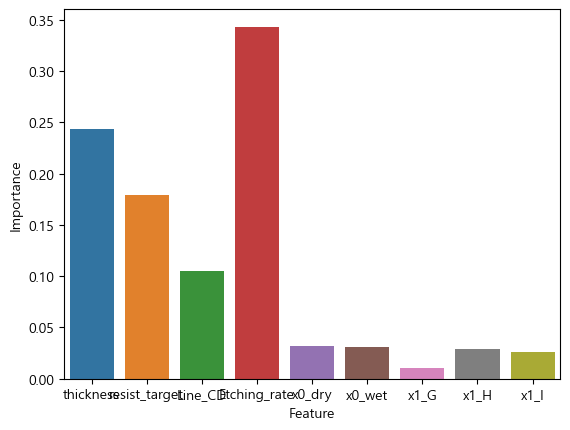

In [16]:
sns.barplot(data = df_importance, x = 'Feature', y = 'Importance')

#### 8. 모델을 파일형태로 저장

In [17]:
pickle.dump(best_model, open('model_best.sav', 'wb'))

# Boosting
- 데이터에서 복원추출된 표본을 알고리즘이 학습해서 구성될 때마다 오차를 줄여나가는 방향으로 학습해서 점진적으로 향상된 모델을 도출하는 방식
- 전통적인 기계학습 모델 중 가장 성능이 좋고 많이 사용됨
- Boosting Model 종류:
    - Ada Boosting (Adaptive Boosting): 이전에 학습된 결과에 잘 반영이 되지 않은 데이터에 대해 Weight (가중치)를 부여해서 복원추출
        - 앞서 분류가 제대로 수행되지 못한 데이터에 대해 가중을 주며 성능 향상시킴
        - 데이터에 이상치가 존재하는 경우, 이상치에 대해 가중을 주며 학습 수행하므로 지속적인 학습에 대해 성능이 개선되지 않을 수 있음
        - 앞서 가중치가 너무 높게 부여되면, 가중치가 낮게 부여된 데이터들에 대해 오분류 가능성 존재
        
    - Gradient Boosting: Ada Boosting 모델에서 이상치가 많거나 너무 높게 Weight에 대해 주변 값들이 오분류 될 가능성이 매우 높음
        - 오분류된 값에 가중치를 부여할 때마다 가중치의 오차의 제곱이 최소가 되는 방향 (최소제곱법)으로 가중치를 함수형태로 업데이트 후 학습
        - 가중치를 최적화하여 (최소제곱법+경사하강법, y값이 최소가 되는 Minimization; 최소화기법) 부여
        - Ada Boosting 모델보다 더욱 민감한 모델 구성
        - 시간이 많이 소요됨 / (학습율을 잘 조절하지 못하는 경우)과적합 
        
    - XGBoosting: Gradient Boosting 모델에 과적합 현상을 방지하기 위해, 규제항 (Regularization)을 추가해서 학습 수행
        - Tree 구조가 복잡해지지 않도록 규제항 (다양하게 선택 적용)을 추가
        - 속도가 더 느려짐
        
    - Light Boosting: Boosting 계열의 모델들이 속도가 매우 저조한 현상을 개선하기 위해 복원추출되는 데이터의 양을 조절해 학습 수행
        - 시간과 자원의 소요를 효과적으로 줄여주는 학습기법
        - XGBoosting 기반으로 구성된 알고리즘이므로 과적합 현상도 적절히 방지
        
    - Catboosting (Categorical Boosting): 범주형 데이터로부터 얻은 OneHotEncoding()된 더미 변수들에 대해 Boosting 기법을 적용해서 학습하는 기법
        - Dummy화 된 변수를 그룹으로 분할해서 학습 및 처리

### 부스팅 모델로 다시 예측

In [19]:
# !pip install --user xgboost

In [21]:
# !pip install --user lightgbm
# !pip install --user catboost

In [23]:
from lightgbm import LGBMClassifier

In [24]:
help(LGBMClassifier)

Help on class LGBMClassifier in module lightgbm.sklearn:

class LGBMClassifier(sklearn.base.ClassifierMixin, LGBMModel)
 |  LGBMClassifier(boosting_type: str = 'gbdt', num_leaves: int = 31, max_depth: int = -1, learning_rate: float = 0.1, n_estimators: int = 100, subsample_for_bin: int = 200000, objective: Union[str, Callable, NoneType] = None, class_weight: Union[Dict, str, NoneType] = None, min_split_gain: float = 0.0, min_child_weight: float = 0.001, min_child_samples: int = 20, subsample: float = 1.0, subsample_freq: int = 0, colsample_bytree: float = 1.0, reg_alpha: float = 0.0, reg_lambda: float = 0.0, random_state: Union[int, numpy.random.mtrand.RandomState, NoneType] = None, n_jobs: int = -1, silent: Union[bool, str] = 'warn', importance_type: str = 'split', **kwargs)
 |  
 |  LightGBM classifier.
 |  
 |  Method resolution order:
 |      LGBMClassifier
 |      sklearn.base.ClassifierMixin
 |      LGBMModel
 |      sklearn.base.BaseEstimator
 |      builtins.object
 |  
 |  Met

#### 1. 파이프라인 만들기

In [28]:
model_pipe = make_pipeline(preprocess_pipe, ADASYN(), LGBMClassifier())
model_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['thickness', 'resist_target',
                                                   'Line_CD', 'Etching_rate']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['type', 'UV_type'])])),
                ('adasyn', ADASYN()), ('lgbmclassifier', LGBMClassifier())])

#### 2. GridSearchCV로 데이터 분할하기

In [29]:
hyper_parameter = {'lgbmclassifier__max_depth': range(5,11),
                  'lgbmclassifier__n_estimators': [50, 100, 200],
                  'lgbmclassifier__learning_rate': [0.1, 0.01, 0.001]}

grid_model = GridSearchCV(model_pipe, param_grid = hyper_parameter, cv = 5, n_jobs = -1, scoring = 'f1')
grid_model.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('knnimputer',
                                                                                          KNNImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['thickness',
                                                                          'resist_target',
                                                                          'Line_CD',
                                                                          'Etching_rate']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['type',
                                                                          'UV_type'])])),
                                       ('adasyn', ADASYN()),
                                       ('lgbmclassifier', LGBMClassifier())]),
             n_jobs=-1,
             param_grid={'lgbmclassifier__learning_rate': [0.1, 0.01, 0.001],
                         'lgbmclassifier__max_depth': range(5, 11),
                         'lgbmclassifier__n_estimators': [50, 100, 200]},
             scoring='f1')

#### 3. 모델의 성능 결과 보기

In [30]:
print(classification_report(Y_train, Y_train_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93       482
         1.0       0.41      0.93      0.57        44

    accuracy                           0.88       526
   macro avg       0.70      0.90      0.75       526
weighted avg       0.94      0.88      0.90       526



In [31]:
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.83      0.89       206
         1.0       0.23      0.50      0.31        20

    accuracy                           0.81       226
   macro avg       0.59      0.67      0.60       226
weighted avg       0.88      0.81      0.84       226



# 비지도학습
- X(설명변수)들 간의 관계(유사성/연관성/기하거리 등)를 이용해서 비슷한 데이터 묶어주거나 유사한 데이터를 확인하고, 차원을 줄여주는 등의 학습기법
    - 1. 군집분석: 데이터 간의 거리 등을 계산해서 인접한 데이터를 묶어주는 작업
    - 2. 연관분석: 각각의 데이터의 유사도를 꼐산해서 비슷한 데이터들을 찾거나 확인하는 분석
    - 3. 차원축소 (PCA): 여러가지 항목들을 수학적 기법을 활용햇허 적은 차원으로 줄여주는 방법
    
- **군집분석 (Clustering)**
    - 계층형 군집분석: 병합/분할 기법을 이용해 가까운 (또는 먼) 위치의 데이터를 묶어나가며 군집을 형성하는 기법 / 알아서 층계를 형성 -> 군집의 수가 알아서 결정
    - 비계층형 군집분석: 데이터 간의 거리나 데이터의 밀도를 이용해서 군집 구성
        / 사용자가 군집수를 직접 지정
    - 잠재공간 군집분석: 잠재공간으로부터 추정된 값을 이용해 군집 구성

In [45]:
from sklearn.cluster import AgglomerativeClustering  # 병합형 계층 군집분석

In [46]:
df1 = pd.read_csv("06_Data.csv")
df1

,Unnamed: 0,Image ID,Diagnosis,Mean Radius,Mean Perimeter,Mean Area,Mean Texture,Mean Smoothness,Mean Compactness,Mean Concavity,...,SE Perimeter,SE Area,SE Texture,SE Smoothness,SE Compactness,SE Concavity,SE Concave Points,SE Symmetry,SE Fractal Dim,Target
0,0,842302,M,17.99,122.80,1001.0,10.38,0.12,0.27760,0.30010,...,8.589,153.40,0.9053,0.0064,0.0490,0.0537,0.0159,0.0300,0.0062,1.0
1,1,842517,M,20.57,132.90,1326.0,17.77,0.08,0.07864,0.08690,...,3.398,74.08,0.7339,0.0052,0.0131,0.0186,0.0134,0.0139,0.0035,0.0
2,2,84300903,M,19.69,130.00,1203.0,21.25,0.11,0.15990,0.19740,...,4.585,94.03,0.7869,0.0062,0.0401,0.0383,0.0206,0.0225,0.0046,1.0
3,3,84348301,M,11.42,77.58,386.1,20.38,0.14,0.28390,0.24140,...,3.445,27.23,1.1560,0.0091,0.0746,0.0566,0.0187,0.0596,0.0092,1.0
4,4,84358402,M,20.29,135.10,1297.0,14.34,0.10,0.13280,0.19800,...,5.438,94.44,0.7813,0.0115,0.0246,0.0569,0.0189,0.0176,0.0051,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,564,926424,M,21.56,142.00,1479.0,22.39,0.11,0.11590,0.24390,...,7.673,158.70,1.2560,0.0103,0.0289,0.0520,0.0245,0.0111,0.0042,1.0
565,565,926682,M,20.13,131.20,1261.0,28.25,0.10,0.10340,0.14400,...,5.203,99.04,2.4630,0.0058,0.0242,0.0395,0.0168,0.0190,0.0025,1.0
566,566,926954,M,16.60,108.30,858.1,28.08,0.08,0.10230,0.09251,...,3.425,48.55,1.0750,0.0059,0.0373,0.0473,0.0156,0.0132,0.0039,1.0
567,567,927241,M,20.60,140.10,1265.0,29.33,0.12,0.27700,0.35140,...,5.772,86.22,1.5950,0.0065,0.0616,0.0712,0.0166,0.0232,0.0062,1.0


In [47]:
X = df1[['Mean Radius', 'Mean Perimeter', 'Mean Area', 'Mean Texture']]

In [48]:
X

,Mean Radius,Mean Perimeter,Mean Area,Mean Texture
0,17.99,122.80,1001.0,10.38
1,20.57,132.90,1326.0,17.77
2,19.69,130.00,1203.0,21.25
3,11.42,77.58,386.1,20.38
4,20.29,135.10,1297.0,14.34
...,...,...,...,...
564,21.56,142.00,1479.0,22.39
565,20.13,131.20,1261.0,28.25
566,16.60,108.30,858.1,28.08
567,20.60,140.10,1265.0,29.33


In [50]:
cluster = AgglomerativeClustering()
cluster.fit(X)

AgglomerativeClustering()

In [51]:
X['cluster'] = cluster.fit_predict(X)

C:\Users\Conet\AppData\Local\Temp\ipykernel_18988\1088527410.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = cluster.fit_predict(X)


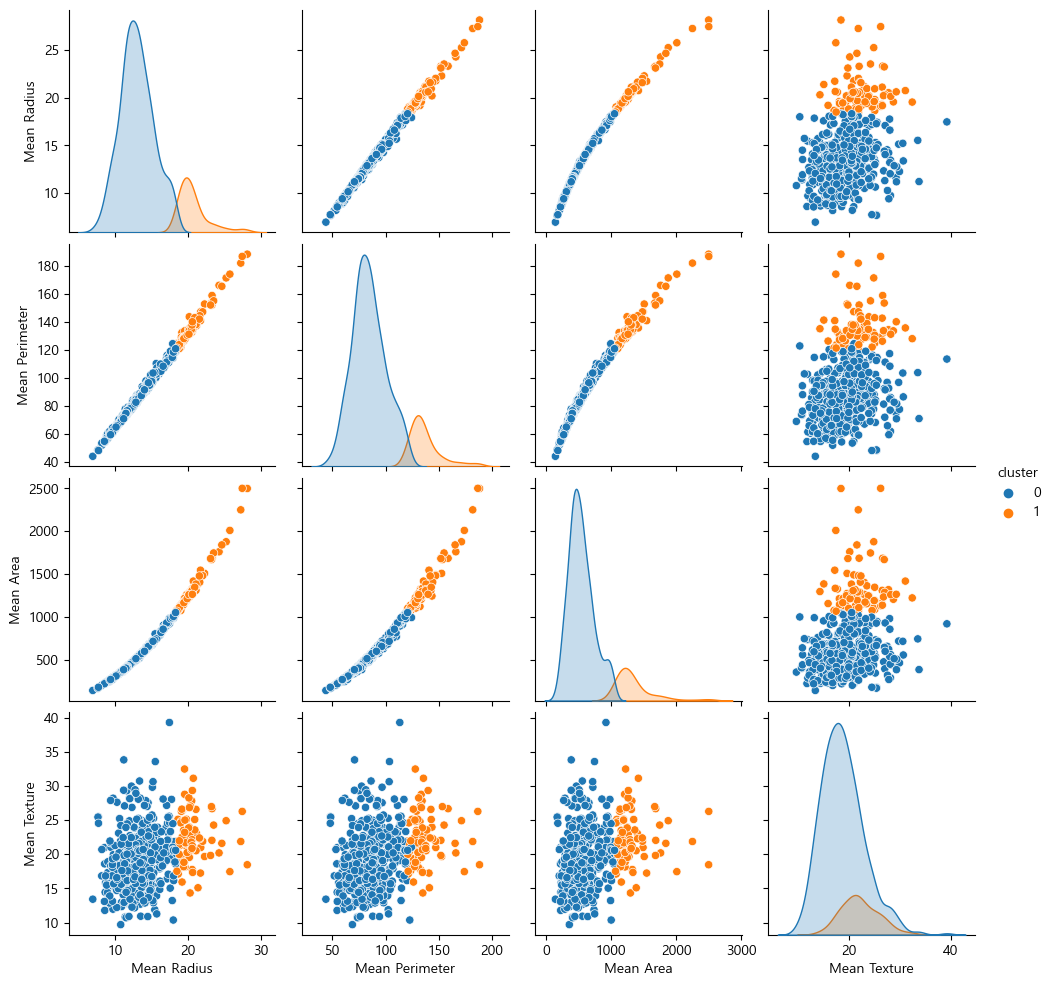

In [52]:
sns.pairplot(data=X, hue = 'cluster')

In [53]:
from sklearn.cluster import KMeans

In [54]:
cluster = KMeans(n_clusters = 4)

In [55]:
cluster.fit(X)

C:\Users\Conet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


KMeans(n_clusters=4)

In [56]:
X['kmeans_cluster'] = cluster.fit_predict(X)
X['kmeans_cluster'].value_counts()

C:\Users\Conet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Conet\AppData\Local\Temp\ipykernel_18988\1884108107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['kmeans_cluster'] = cluster.fit_predict(X)


0    268
1    186
3    102
2     13
Name: kmeans_cluster, dtype: int64

C:\Users\Conet\anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


C:\Users\Conet\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


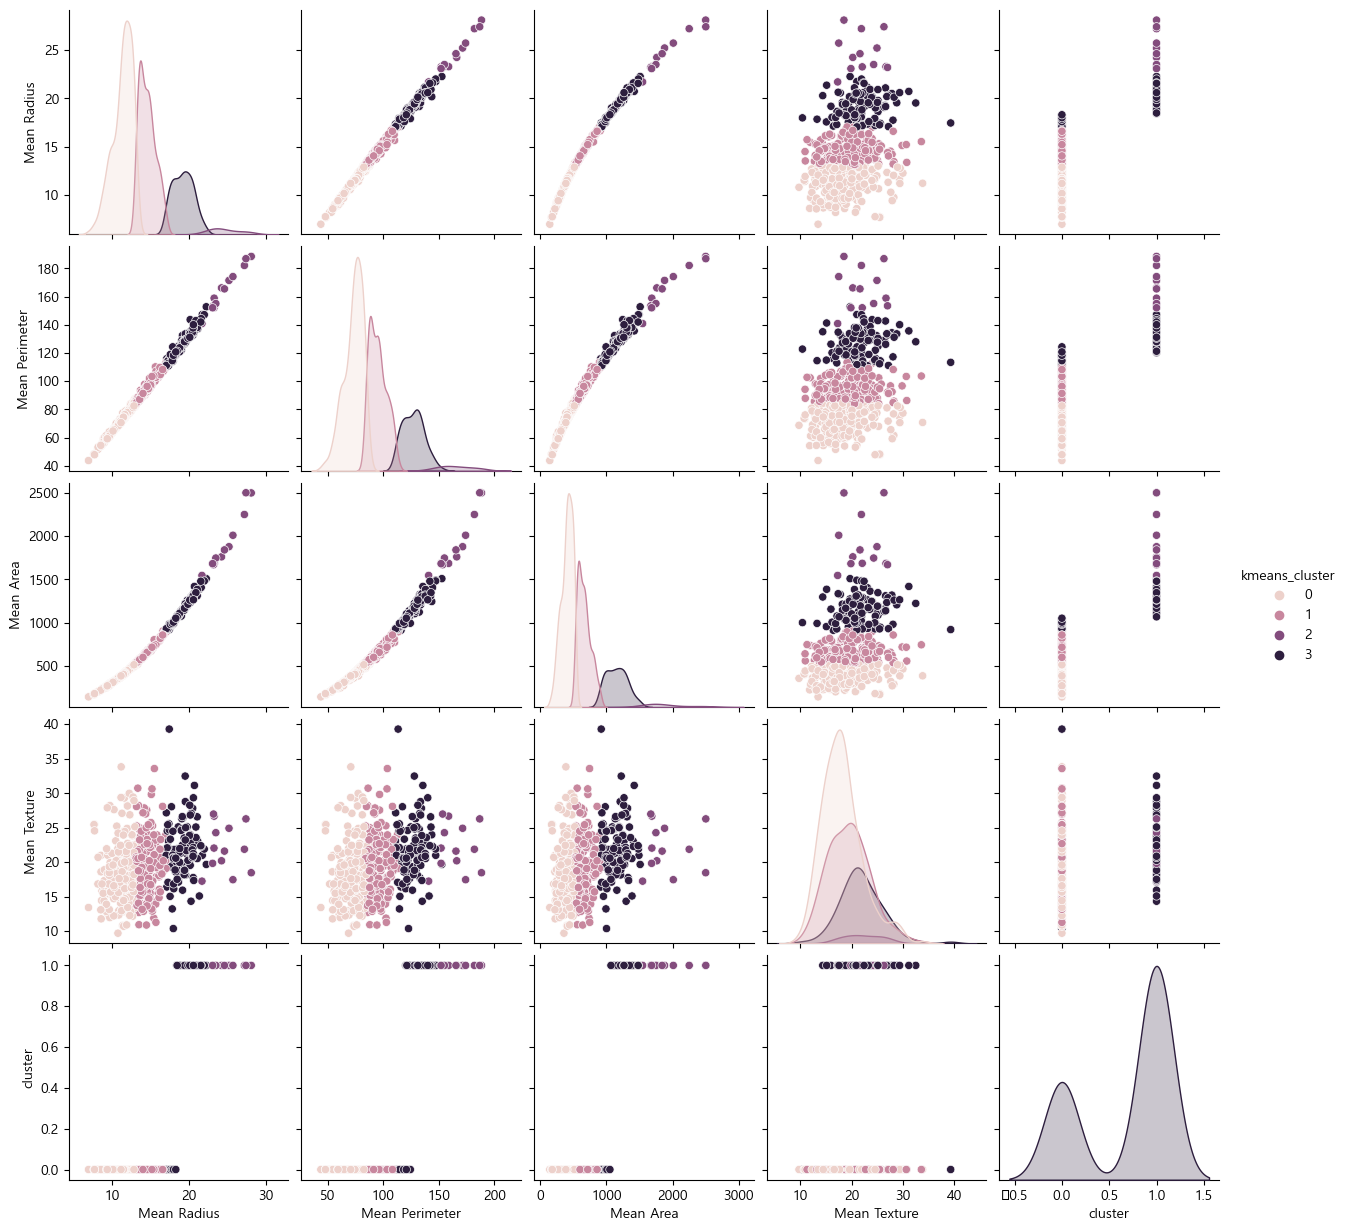

In [57]:
sns.pairplot(data = X, hue = 'kmeans_cluster')

# 실루엣 계수를 이용한 분석
- 실루엣 값: 같은 군집 내 데이터가 얼마나 잘 모여있는가, 서로 다른 군집끼리 데이터가 얼마나 떨어져 있는가를 수치화한 지표 **<참고사항>**

In [58]:
from sklearn.metrics import silhouette_score

In [59]:
X

,Mean Radius,Mean Perimeter,Mean Area,Mean Texture,cluster,kmeans_cluster
0,17.99,122.80,1001.0,10.38,0,3
1,20.57,132.90,1326.0,17.77,1,3
2,19.69,130.00,1203.0,21.25,1,3
3,11.42,77.58,386.1,20.38,0,0
4,20.29,135.10,1297.0,14.34,1,3
...,...,...,...,...,...,...
564,21.56,142.00,1479.0,22.39,1,3
565,20.13,131.20,1261.0,28.25,1,3
566,16.60,108.30,858.1,28.08,0,1
567,20.60,140.10,1265.0,29.33,1,3


In [60]:
X_feature = X[['Mean Radius', 'Mean Perimeter', 'Mean Area', 'Mean Texture']]

In [61]:
silhouette_score(X_feature, X['kmeans_cluster'])

0.5587597139763499

In [62]:
# 몇개의 군집으로 만들었을 때 가장 적절한지 확인하기
for i in range(2,6):
    cluster = KMeans(n_clusters= i )
    cluster.fit(X_feature)
    X_cluster = cluster.fit_predict(X_feature)
    print(i, '개의 군집 silhouette:', silhouette_score(X_feature, X_cluster))

C:\Users\Conet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Conet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


2 개의 군집 silhouette: 0.6991356519247057


C:\Users\Conet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Conet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


3 개의 군집 silhouette: 0.5653581270681922


C:\Users\Conet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Conet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


4 개의 군집 silhouette: 0.5585054969829115


C:\Users\Conet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Conet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


5 개의 군집 silhouette: 0.5403344746182871
